<a href="https://colab.research.google.com/github/146790g/VGG19-BreakHis/blob/master/BreakHis_VGG19_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層学習 VGG19モデルを用いた乳がん染色画像（BreakHis）の解析
#（その３ : Image Feature Extraction ）
# Deep Learning for Magnification Independent Breast Cancer Histopathology

<br>

# Image Classification using VGG19 Model - Image Feature Extraction

<br>


<h2>対象データは、こちらをクリック ☞　</>
<a href='https://www.kaggle.com/ambarish/breakhis'>Kaggle BreakHis Data</a>

４つのMagnification levelのデータをすべて合算して、解析する

<br>

## 4 Magnification Levels: ×40, ×100, ×200, ×400


During analysis and annotation, pathologists starts by identifying ROIs in
the lowest magnification level slide (×40), then dives deeper in the latter using higher magnification levels (×100, ×200) until having a profound insight
(×400). 

<br>

## データ数 の概要

・Training Data: 5026 images <br>
  -- Benign Data: 1472 images <br>
  -- Mallignant Data: 3554 images 

・Validation Data: 2904 images <br>
  -- Benign Data: 1008 images <br>
  -- Mallignant Data:1896 images <br>

## Data Set Details by Magnification levels.

 ×40 : <br>
×100 : <br>
×200 : <br>
×400 : <br>

In [3]:
%tensorflow_version 2.x

In [4]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data'

total 8.0K
drwx------ 2 root root 4.0K Jul 21 03:42 train
drwx------ 2 root root 4.0K Jul 27 01:49 validation


In [6]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

    


## 第６章 特徴データの抽出


### テストデータの正常組織の画像のすべてを4階テンソルの配列データに変換する

In [9]:
train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train' # 訓練データのフォルダー
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/validation' # テストデータのフォルダー
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results'        # VGG19の出力結果を保存するフォルダー
test_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/test'
    
import os 

files=os.listdir(os.path.join(test_dir,'benign'))

test_img_array_list = []

for img in files:
  
    file=os.path.join(test_dir,'benign', img)
    temp_img = load_img(file,target_size=(400,400))

    #PIL形式からNumpy配列に変換と正規化(400, 400, 3)
    temp_img_array = img_to_array(temp_img) /255

    #変換したNumpy配列を末尾に追加
    test_img_array_list.append(temp_img_array)

    
import numpy as np


test_benign = np.array(test_img_array_list)

print(type(test_benign))
print(test_benign.shape)


<class 'numpy.ndarray'>
(60, 400, 400, 3)


###  テストデータのうち、乳癌組織の画像データを4階のテンソルの配列データに変換する

In [11]:
import os 

files=os.listdir(os.path.join(test_dir,'malignant'))

test_img_array_list = []

for img in files:
  
    file=os.path.join(test_dir,'malignant', img)
    temp_img = load_img(file,target_size=(400,400))

    #PIL形式からNumpy配列に変換と正規化(400, 400, 3)
    temp_img_array = img_to_array(temp_img) /255

    #変換したNumpy配列を末尾に追加
    test_img_array_list.append(temp_img_array)

    
import numpy as np


test_malignant = np.array(test_img_array_list)

print(type(test_malignant))
print(test_malignant.shape)

<class 'numpy.ndarray'>
(75, 400, 400, 3)


### 4階テンソルデータに基づいて、特徴データを抽出する

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

model=load_model(os.path.join(result_dir,'breakhis_vgg19model_parameter.h5'))

layer_outputs = model.get_layer('dense').output

model2 = models.Model(inputs=model.input, outputs=layer_outputs)


# 正常組織の特徴量データ
dense_output_benign =model2.predict(test_benign)

#乳癌組織の特徴量データ
dense_output_malignant=model2.predict(test_malignant)

# 合算して、特徴量データをfeatureと命名する

feature = np.concatenate([dense_output_benign, dense_output_malignant], axis=0)

print(feature.shape)

(135, 256)


### ラベルデータを作成する

In [52]:
l1 = [0] * 60
l2= [1]*75
label=l1+l2

labeld=np.array(label)

print(labeld.shape)
print(labeld)




(135,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### 特徴量データに基づいて、tSNEプロットを作成する

In [53]:
from sklearn.manifold import TSNE
digits2d = TSNE(n_components=2).fit_transform(feature)

print(digits2d)
print(digits2d.shape)

[[-7.84222424e-01  1.12138438e+00]
 [-5.85731077e+00 -2.70905828e+00]
 [-1.53479087e+00  4.07335711e+00]
 [-1.98808277e+00  4.66628122e+00]
 [ 3.04658699e+00  1.00671406e+01]
 [ 4.05044889e+00  1.14574900e+01]
 [ 6.03734236e-03  1.61850893e+00]
 [ 1.68369591e+00  8.51485062e+00]
 [ 1.14226604e+00  8.81165791e+00]
 [ 4.90793228e+00  1.03796663e+01]
 [ 1.96507931e+00  8.62656307e+00]
 [ 2.65068024e-01  7.40385437e+00]
 [ 1.92053652e+00  9.31626320e+00]
 [ 5.13166809e+00  1.09186926e+01]
 [ 2.24238276e+00  9.56262207e+00]
 [-1.86994600e+00  7.79171467e-01]
 [ 4.76760417e-01  8.62444210e+00]
 [-4.71001816e+00  3.33771658e+00]
 [-1.46606135e+00  4.84674835e+00]
 [ 3.82575512e+00  1.03671951e+01]
 [-4.56899069e-02  8.46242428e+00]
 [ 2.83745170e+00  9.70630074e+00]
 [ 5.36282444e+00  9.24415398e+00]
 [-5.35786033e-01  7.01934910e+00]
 [ 1.98082733e+00  9.91138363e+00]
 [-2.72759408e-01  5.70522070e+00]
 [ 5.36982584e+00  1.11672392e+01]
 [-2.09080979e-01  1.20236969e+00]
 [ 3.84419608e+00  1

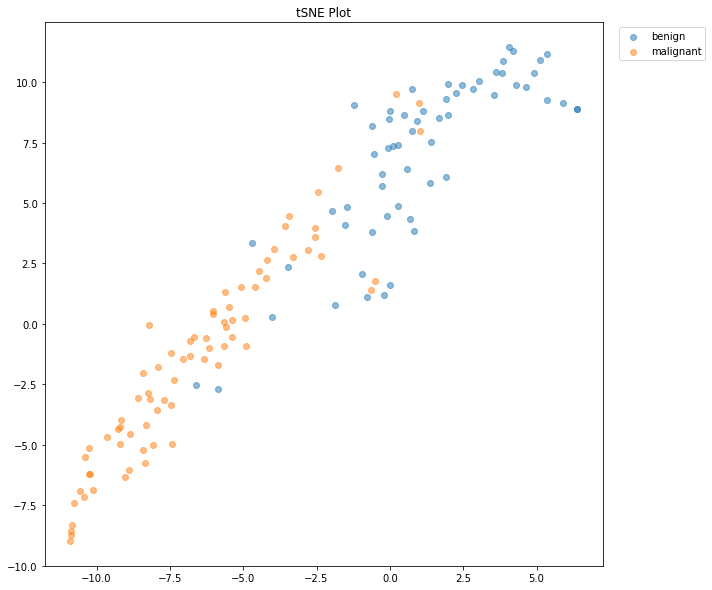

In [55]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

name=['benign','malignant']

for i in range(2):
  target = digits2d[labeld == i]
  ax.scatter(x=target[:, 0], y=target[:, 1], label=name[i], alpha=0.5)
  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
  plt.title('tSNE Plot')

## 【考察】

特徴量データに基づいて、tSNEプロットを作成したところ、正常と乳癌組織で、ほぼ的確に、分類されることが確認された。
画像データを、特徴量データのデジタルデータに変換することで、そのほかのRNAseqデータ等と統合的に解析できる道が開かれた。